# BMDA Trajectory Classification Demo

## Authors: Amilcar Soares, Yaksh J Haranwala
## Version: 1.0, January 6, 2022

# Pre-processing (Step 1)
## Reading and indexing Trajectory Data
First we start by reading trajectory data using PTRAIL, which will provide the data structures necessary to handle the spatio-temporal dependencies on the data. 

In [6]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load the dataset that we will be performing some machine learning tasks on.
df = pd.read_csv('https://raw.githubusercontent.com/YakshHaranwala/PTRAIL/main/examples/data/starkey.csv')
starkey = PTRAILDataFrame(data_set=df,
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')
print(starkey)

------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


# Pre-processing (Step 2)
## Create Trajectory Features (Feature engineering)

Generate the kinematic statistics.
This method creates first a point-based representation for features: distance between points distance travelled from start, speed (m/s), acceleration (m/s2), jerk, bearing, bearing rate, and rate of bearing rate (8 point features). 
After, the method extracts statistics from all these features, including: 
minimum, maximal, standard deviation, mean, and percentiles 10, 25, 50, 75 and 90.
The statistics extracted are a trajectory(segment)-based representation of the trajectory dataset and can be used for several problems. 
For data visualization purposes, the outcomes of this method are grouped by 
point-feature attribute. 

In [7]:
%%time
stats = Statistics.generate_kinematic_stats(dataframe=starkey,
                                            target_col_name='Species')
stats.head(14)

CPU times: user 42.5 s, sys: 854 ms, total: 43.4 s
Wall time: 44.7 s


mean          std        min  \
traj_id   Columns                                                     
910313E37 Distance               268.728974   398.901980   0.000000   
          Distance_from_start   2991.413513  1502.135300  67.090679   
          Speed                    0.090286     0.351682   0.000000   
          Acceleration             0.000169     0.003805  -0.003872   
          Jerk                     0.000002     0.000075  -0.000062   
          Bearing                175.248705   106.277853   0.000000   
          Bearing_Rate            -0.001945     0.154034  -6.036678   
          Rate_of_bearing_rate    -0.001945     0.154034  -6.036678   
890424E08 Distance               323.956468   446.249248   0.000000   
          Distance_from_start   1780.438321  1009.296449  30.022290   
          Speed                    0.126648     0.627852   0.000000   
          Acceleration             0.000406     0.009098  -0.011316   
          Jerk                     0.000008     0.000276  -0.000289   
          Bearing                171.731080   104.887878   0.000000   

                                         10%           25%           50%  \
traj_id   Columns                                                          
910313E37 Distance              3.002236e+01  6.695679e+01  1.496120e+02   
          Distance_from_start   1.121185e+03  1.910512e+03  2.897754e+03   
          Speed                 8.259408e-03  1.615503e-02  3.359295e-02   
          Acceleration         -2.424220e-05 -6.195019e-06 -1.586024e-08   
          Jerk                 -1.388547e-08 -2.115955e-09  3.702679e-10   
          Bearing               3.630453e+01  8.002068e+01  1.789011e+02   
          Bearing_Rate         -6.332204e-02 -2.667698e-02  5.306679e-08   
          Rate_of_bearing_rate -6.332204e-02 -2.667698e-02  5.306679e-08   
890424E08 Distance              4.238464e+01  8.478037e+01  1.772234e+02   
          Distance_from_start   6.741700e+02  1.091723e+03  1.625730e+03   
          Speed                 8.839622e-03  1.689185e-02  3.648584e-02   
          Acceleration         -2.742458e-05 -6.594604e-06  2.646463e-08   
          Jerk                 -1.644760e-08 -1.938503e-09  3.326526e-10   
          Bearing               3.250860e+01  7.939917e+01  1.788948e+02   

                                         75%           90%          max  \
traj_id   Columns                                                         
910313E37 Distance              3.007269e+02  6.322696e+02  6034.207873   
          Distance_from_start   3.756909e+03  5.051656e+03  8113.437916   
          Speed                 7.204029e-02  1.547846e-01    11.977635   
          Acceleration          7.442440e-06  2.916966e-05     0.186919   
          Jerk                  4.593905e-09  1.898648e-08     0.003555   
          Bearing               2.688819e+02  3.178710e+02   358.924608   
          Bearing_Rate          2.507170e-02  6.531603e-02     2.449554   
          Rate_of_bearing_rate  2.507170e-02  6.531603e-02     2.449554   
890424E08 Distance              3.796140e+02  7.593111e+02  6043.490157   
          Distance_from_start   2.302306e+03  2.952259e+03  7440.052757   
          Speed                 8.519257e-02  1.888782e-01    18.913689   
          Acceleration          8.261376e-06  3.706895e-05     0.456125   
          Jerk                  5.344698e-09  2.597998e-08     0.011693   
          Bearing               2.607450e+02  3.140025e+02   358.918311   

                                Species  
traj_id   Columns                        
910313E37 Distance                    1  
          Distance_from_start         1  
          Speed                       1  
          Acceleration                1  
          Jerk                        1  
          Bearing                     1  
          Bearing_Rate                1  
          Rate_of_bearing_rate        1  
890424E08 Distance                    1  
          Distance_fro

# Pre-processing (Step 3)
## Pivot the frame to create a feature vector
To change the representation in a way we can assign one label per trajectory (segment)
The user just need to call the method pivot_stats_df and all trajectory-based features will be pivoted for machine learning tasks as can be seen below

In [8]:
pivoted_stats = Statistics.pivot_stats_df(dataframe=stats,
                                          target_col_name='Species')
pivoted_stats.head(5)

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,Species
traj_id,,,,,,,,,,,,,,,,,,,,,
910313E37,30.022359,66.956787,149.611989,300.726867,632.269559,0.0,6034.207873,268.728974,398.901980,1121.185006,...,-0.063322,-0.026677,5.306679e-08,0.025072,0.065316,-6.036678,2.449554,-0.001945,0.154034,1
890424E08,42.384642,84.780370,177.223376,379.614004,759.311144,0.0,6043.490157,323.956468,446.249248,674.170024,...,-0.064023,-0.023545,0.000000e+00,0.022320,0.063820,-11.536372,2.494857,-0.006703,0.241358,1
921228E06,42.390114,90.066813,200.849995,429.158672,890.194719,0.0,4623.347553,377.677630,517.650637,807.693739,...,-0.058033,-0.020736,-9.056581e-07,0.020104,0.056057,-56.020652,4.466711,-0.016681,1.008263,1
930304E16,42.384012,67.090258,153.068542,341.254645,690.640774,0.0,5864.020183,291.351804,396.220730,1156.455188,...,-0.068092,-0.026542,2.094546e-07,0.027375,0.066328,-7.865121,30.406105,0.001768,0.600187,1
940110D01,30.022192,66.956668,149.612107,284.710015,510.276991,0.0,1975.611748,221.420080,235.093739,492.522877,...,-0.041207,-0.018263,0.000000e+00,0.018564,0.042032,-5.547235,200.192244,0.073830,3.677063,0


# 2. Trajectory Classification

Now that we have swapped from a point-based representation to a trajectory-based one, we can simply slice and export the PTRAILDataFrame data to be used with scikit-learn. We use in this demonstration Random Forest, Extra Trees, and Gradient Boosting with a 10-fold cross-validation. We use f-score as the performance metric since our data is imbalanced. Finally, we use Seaborn to produce a boxplot aiming at evaluating the spread of the result of the 10-fold cross-validation

### Insights

If you look at the boxplot, we can observe that the results are competitive. However, Random Forests and Extra Trees produced less variance in the f-scores obtained and therefore seem to be a bit more stable in this dataset. 

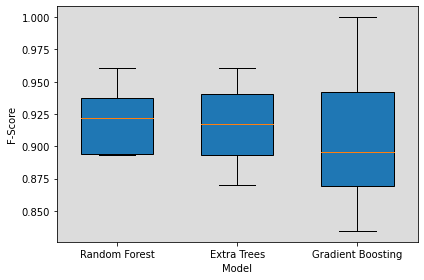

In [9]:
# Models.
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# Metric calculation.
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Data viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Declare all the models that we are going to train.
seed = 7
names = ["Random Forest", "Extra Trees", "Gradient Boosting"]
models = [RandomForestClassifier(random_state=seed), 
          ExtraTreesClassifier(random_state=seed),
          GradientBoostingClassifier(n_estimators=10, learning_rate=.3, max_depth=1, random_state=seed)]

# Convert the dataframe and its answer value to numpy.
X = pivoted_stats.drop(columns='Species')
Y = pivoted_stats['Species'].to_numpy()

ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
# For each model defined above, predict the species for
# our animals.
for i, name, model in zip(range(0, 4), names, models):
    scores = cross_val_score(model, X, Y,
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i],
               vert=True, widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("F-Score")
ax.set_xlabel("Model")
plt.tight_layout()

# 3. Dimensionality Reduction for decision surface visualization

Finally, we reduce the 72 attributes to two components using PCA. 
Then, we create a grid of instances to explore how the models would classify the animals using the reduced dimensions. We use a combination of scikit-learn, numpy, and seaborn to produce the surface plot. 

### Insights.

The plots show that Random Forests seem to define better how to classify the three classes, followed by Extra Trees. We also notice that Gradient Boosting was not able to generalize well a classification surface for Elks. 

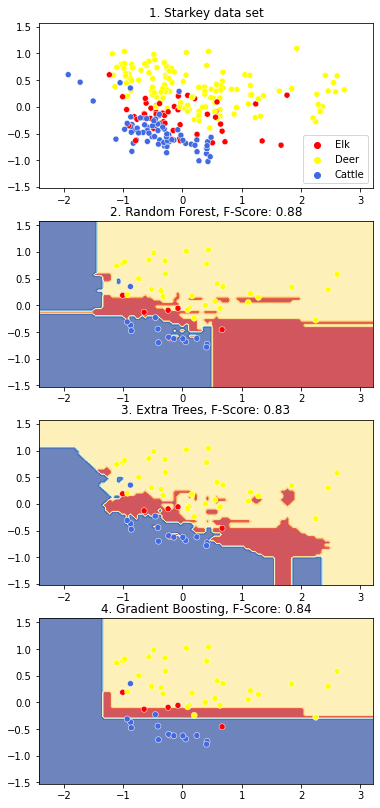

In [10]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import numpy as np

seed = 34
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
Xt = pca.fit_transform(X=X)
X_train, X_test, y_train, y_test = train_test_split(Xt, Y, test_size=0.2, random_state=seed)

# Perform PCA on our df and extract 2 components for visualization purposes.


# Prepare next figure
fig2, ax2 = plt.subplots(4, 1, figsize=(6, 14))
fig2.set_facecolor('white')
ax2=ax2.flatten()

h = 0.05
x_min, x_max = Xt[:, 0].min() - .5, Xt[:, 0].max() + .5
y_min, y_max = Xt[:, 1].min() - .5, Xt[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdYlBu
cm_bright = ListedColormap(["#FF0000", "#FFFF00", "#00FF00"])

ax2[0].set_title("1. Starkey data set")
# Plot all points of the dataset.
sns.scatterplot(x=Xt[:, 0], y=Xt[:, 1],
                  hue=Y, ax=ax2[0], palette=['red', 'yellow', 'royalblue'])
ax2[0].set_xlim(xx.min(), xx.max())
ax2[0].set_ylim(yy.min(), yy.max())
handles, labels  =  ax2[0].get_legend_handles_labels()
ax2[0].legend(handles, ['Elk', 'Deer', 'Cattle'], loc='lower right')

for i, name, model in zip(range(1, len(ax2)), names, models):
      model.fit(X_train, y_train)      
      hue = model.predict(X_test)
      score = f1_score(y_test, hue, average='weighted')
      # Plot the decision boundary. For that, we will assign a color to each
      # point in the mesh [x_min, x_max]x[y_min, y_max].
      Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
      # Reshape the array and then plot the contour plot.
      Z = Z.reshape(xx.shape)
      ax2[i].contourf(xx, yy, Z, cmap=cm, alpha=0.75)

      # Now, we plot the points onto the contour and then map their
      # colors according to the regions.
      sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1],
                      hue=y_test, ax=ax2[i], palette=['red', 'yellow', 'royalblue'])

      ax2[i].set_title(f'{i+1}. {name}, F-Score: {round(score, 2)}')
      ax2[i].get_legend().remove()
  # plt.show()